In [2]:
import pandas as pd
#import faiss

import os
import joblib
from collections import defaultdict
from IPython.display import IFrame, Image

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import zipfile

In [3]:
!pip install faiss-cpu

In [4]:
import faiss

In [5]:
# загрузим датасеты:

In [6]:
base = pd.read_csv("C:/Users/andrey/Documents/мастерская данных_2/base.csv")

In [7]:
base_mini = pd.read_csv("C:/Users/andrey/Documents/мастерская данных_2/base_mini.csv", index_col=0)

In [8]:
train_mini = pd.read_csv("C:/Users/andrey/Documents/мастерская данных_2/train_mini.csv", index_col=0)

In [9]:
validation_answer_mini = pd.read_csv("C:/Users/andrey/Documents/мастерская данных_2/validation_answer_mini.csv", index_col=0)

In [10]:
validation_mini = pd.read_csv("C:/Users/andrey/Documents/мастерская данных_2/validation_mini.csv", index_col=0)

In [11]:
#base.head()

In [12]:
#base.describe()

In [13]:
#base.info()

изучим группу файлов мини :

In [14]:
base_mini.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
6-base,-132.349780,12.640369,-80.635895,-137.11795,89.345490,-94.853520,-462.934000,91.356030,126.557274,147.39490,...,-55.650047,29.008305,-138.24612,156.300500,67.05420,-25.324776,85.734146,138.85352,-1070.5162,-2.041809
10-base,-98.898865,5.633918,-88.647285,-158.90100,87.810620,-76.610000,6.748629,-27.250978,126.672390,120.37991,...,-81.505670,19.662066,-125.73326,18.915530,67.41328,48.166084,146.343660,117.06042,-1152.3021,-73.153015
12-base,-68.859090,-0.939237,-47.824863,-153.82768,89.371060,-83.141740,-529.278500,39.693317,118.244225,140.70552,...,-58.820076,76.393720,-180.40990,85.385710,67.94069,-20.363410,162.172640,120.76160,-1092.4850,-64.907616
13-base,-71.780470,9.491869,-80.955360,-105.35263,84.318450,-78.632150,-429.259030,108.983040,124.514730,138.17792,...,-29.982979,40.114300,-138.04740,59.624220,68.61810,71.057980,95.904850,141.27716,-1205.3022,-51.975533
14-base,-121.066216,6.920069,-134.866850,-132.77559,19.703812,-37.102016,83.941820,-78.876540,125.779030,86.25271,...,-64.943320,56.583214,-239.40808,76.244835,64.53448,66.593765,109.980560,141.34575,-1074.4648,-156.521820


In [15]:
base_mini.shape

(583600, 72)

In [16]:
train_mini.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
1-query,-87.77637,6.806268,-32.054546,-177.26039,120.80333,-83.810590,-94.57275,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.09220,-51.276833,366656-base
14-query,-107.74551,8.262278,1.303707,-122.30960,124.88633,-113.067260,-759.62604,-50.134230,125.86170,107.053070,...,19.192116,-169.01462,129.329820,69.071840,-21.853165,91.174060,86.220680,-951.97925,-119.347946,88328-base
17-query,-64.54115,6.379174,22.827354,-140.19008,118.12147,-45.949470,-167.82553,76.232230,116.56160,36.988052,...,68.939440,-232.42427,-151.365800,66.982070,21.464298,31.847046,125.621956,-1179.73110,-48.768707,1841709-base
21-query,-41.34329,12.988533,-52.500470,-177.08405,117.42550,-64.219170,-759.62604,119.854680,116.59877,28.824615,...,33.574203,-140.07430,-74.130066,70.309480,22.298388,53.082397,113.545525,-653.41100,8.083492,9331-base
24-query,-133.16289,-2.366189,-24.341312,-163.20690,136.80786,-64.591225,-759.62604,0.566725,121.06721,166.230510,...,21.065586,-151.60904,21.146963,71.008780,-37.431760,57.041412,141.719480,-1181.58060,-36.334442,915740-base


In [17]:
train_mini.shape

(20000, 73)

In [18]:
validation_mini.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100004-query,-79.53292,-0.364173,-16.027431,-170.88495,165.453920,-28.291668,33.931934,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.89230,-125.307890
100005-query,-89.74536,6.317698,-80.744650,-114.53197,153.960340,-74.897130,-208.928700,-32.214005,115.582855,61.603172,...,-64.934890,37.824436,-153.04173,-131.257920,68.26281,56.239280,120.64690,76.342550,-1156.99290,-72.146390
100007-query,-119.02685,7.536469,-62.973827,-142.94609,150.376110,-92.343550,-530.124700,24.280703,124.623260,119.622160,...,-121.699980,49.379295,-211.29207,37.299725,68.56667,21.038134,37.36427,116.667170,-1129.24290,-87.194520
100010-query,-57.71042,5.344710,-36.634872,-151.92635,123.258860,-82.446480,-530.124700,54.023262,118.234550,181.625780,...,-61.568954,35.105920,-134.64563,-7.372177,69.39937,16.125835,202.46930,120.868460,-195.12244,-121.981840
100013-query,-113.83982,5.682194,-7.384804,-142.80922,63.082832,-69.850624,-759.626040,31.846502,120.052260,121.982080,...,-60.315765,45.007620,-147.07414,34.577280,65.68382,251.287280,96.05116,110.661316,-560.48190,-13.711834


In [19]:
validation_mini.shape

(20000, 72)

In [20]:
validation_answer_mini.head()

,Expected
Id,
100004-query,75484-base
100005-query,1905037-base
100007-query,1533713-base
100010-query,641788-base
100013-query,11032-base


In [21]:
validation_answer_mini.shape

(20000, 1)

Оценим признаки на предмет полкезных и нет , проверку будем проводить на mini выборке.

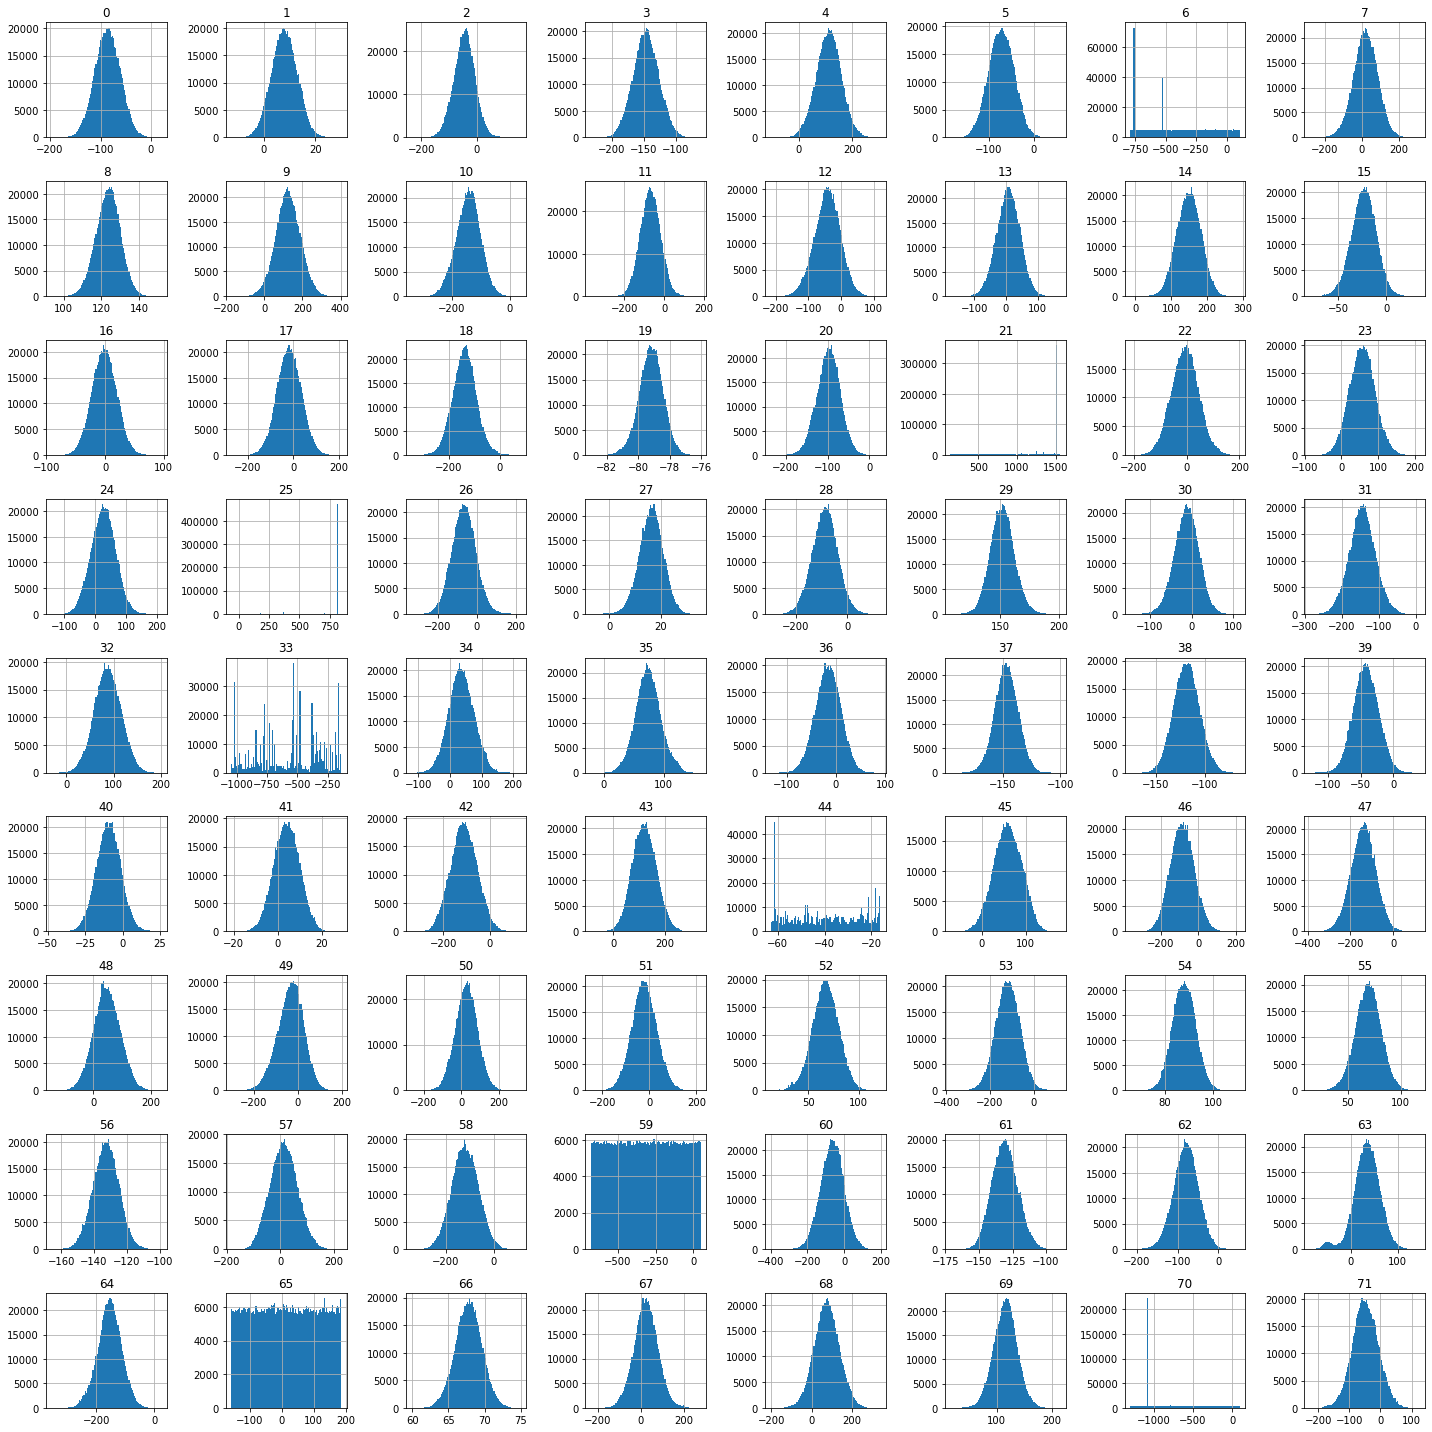

In [22]:
plt.rcParams['figure.figsize'] = (20,20)
base_mini.hist(bins=100)
plt.tight_layout()
plt.show()

In [23]:
#plt.figure(figsize=(20, 10))
#plt.title('Корреляция признаков', weight = 'bold')
#cmap = sns.diverging_palette(230, 40, as_cmap=True)
#sns.heatmap(base_mini.corr(method='spearman'), annot = True, cmap=cmap)
#plt.show()

Хотел посмотреть корреляцию признаков , но упс-( 

исходя из анализа распределения признаков , считаю , что признаки 6,21,25,33,44,59,70 стоит не использовать.

In [30]:
base_mini.drop(['6','21','25','33','44','59','70'], axis=1)

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,65,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
6-base,-132.349780,12.640369,-80.635895,-137.11795,89.345490,-94.853520,91.356030,126.557274,147.394900,-181.880570,...,-129.899430,-55.650047,29.008305,-138.24612,156.300500,67.054200,-25.324776,85.734146,138.853520,-2.041809
10-base,-98.898865,5.633918,-88.647285,-158.90100,87.810620,-76.610000,-27.250978,126.672390,120.379910,-69.643310,...,-135.847020,-81.505670,19.662066,-125.73326,18.915530,67.413280,48.166084,146.343660,117.060420,-73.153015
12-base,-68.859090,-0.939237,-47.824863,-153.82768,89.371060,-83.141740,39.693317,118.244225,140.705520,-106.737180,...,-127.555880,-58.820076,76.393720,-180.40990,85.385710,67.940690,-20.363410,162.172640,120.761600,-64.907616
13-base,-71.780470,9.491869,-80.955360,-105.35263,84.318450,-78.632150,108.983040,124.514730,138.177920,-122.214066,...,-147.556930,-29.982979,40.114300,-138.04740,59.624220,68.618100,71.057980,95.904850,141.277160,-51.975533
14-base,-121.066216,6.920069,-134.866850,-132.77559,19.703812,-37.102016,-78.876540,125.779030,86.252710,-96.232850,...,-123.042885,-64.943320,56.583214,-239.40808,76.244835,64.534480,66.593765,109.980560,141.345750,-156.521820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744645-base,-61.666348,2.128685,-81.667890,-153.11717,90.409004,-50.814976,60.496810,131.961060,125.705740,-104.835660,...,-110.129380,-82.390205,52.687057,-223.23328,89.548410,69.807460,-9.407581,71.633080,109.317825,-62.755093
4744696-base,-73.158480,15.294069,-57.684612,-132.70872,110.756645,-52.717903,43.640730,120.021980,71.496864,-161.446380,...,-130.168600,-46.570827,60.281837,-242.37354,-40.945374,69.617800,87.411440,155.483200,117.528400,-7.836151
4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,137.317690,129.056690,164.754240,-153.498460,...,-123.761055,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-90.800400


In [31]:
train_mini.drop(['6','21','25','33','44','59','70'], axis=1)

,0,1,2,3,4,5,7,8,9,10,...,62,63,64,65,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-78.433090,124.915900,140.331070,-177.605800,...,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-51.276833,366656-base
14-query,-107.745510,8.262278,1.303707,-122.30960,124.886330,-113.067260,-50.134230,125.861700,107.053070,-90.002630,...,-77.386720,19.192116,-169.014620,129.329820,69.071840,-21.853165,91.174060,86.220680,-119.347946,88328-base
17-query,-64.541150,6.379174,22.827354,-140.19008,118.121470,-45.949470,76.232230,116.561600,36.988052,-158.484090,...,-99.924270,68.939440,-232.424270,-151.365800,66.982070,21.464298,31.847046,125.621956,-48.768707,1841709-base
21-query,-41.343290,12.988533,-52.500470,-177.08405,117.425500,-64.219170,119.854680,116.598770,28.824615,-170.582230,...,-48.169018,33.574203,-140.074300,-74.130066,70.309480,22.298388,53.082397,113.545525,8.083492,9331-base
24-query,-133.162890,-2.366189,-24.341312,-163.20690,136.807860,-64.591225,0.566725,121.067210,166.230510,-121.215070,...,-66.291520,21.065586,-151.609040,21.146963,71.008780,-37.431760,57.041412,141.719480,-36.334442,915740-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984-query,-90.368416,14.155788,-87.071260,-186.35990,-18.529205,-39.364513,77.080170,119.134410,147.413820,-59.577606,...,-67.090576,41.999490,-192.705470,-144.612370,65.208270,67.556820,81.697190,131.575740,-31.511417,282254-base
99989-query,-97.648476,9.691613,-103.170654,-134.14374,145.652220,5.292122,106.803535,128.461800,182.251240,-155.939820,...,-96.796234,1.499683,-122.638110,-155.187900,66.332890,-25.069653,120.186844,131.445980,-57.181810,635083-base
99990-query,-38.032570,11.494578,-19.129005,-152.18866,160.067350,-34.408794,-49.531387,122.104390,215.504090,-112.089294,...,-124.085050,50.564724,-229.965060,-23.577913,65.918846,18.661448,17.368996,93.971550,-73.878000,616075-base


In [32]:
validation_mini.drop(['6','21','25','33','44','59','70'], axis=1)

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,65,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.453920,-28.291668,34.411217,128.903980,102.086914,-76.21417,...,-135.570360,-123.770250,45.635944,-134.258930,13.735359,70.617630,15.332115,154.56812,101.700640,-125.307890
100005-query,-89.745360,6.317698,-80.744650,-114.53197,153.960340,-74.897130,-32.214005,115.582855,61.603172,-169.00420,...,-132.702670,-64.934890,37.824436,-153.041730,-131.257920,68.262810,56.239280,120.64690,76.342550,-72.146390
100007-query,-119.026850,7.536469,-62.973827,-142.94609,150.376110,-92.343550,24.280703,124.623260,119.622160,-69.52861,...,-147.383130,-121.699980,49.379295,-211.292070,37.299725,68.566670,21.038134,37.36427,116.667170,-87.194520
100010-query,-57.710420,5.344710,-36.634872,-151.92635,123.258860,-82.446480,54.023262,118.234550,181.625780,-144.23557,...,-135.918410,-61.568954,35.105920,-134.645630,-7.372177,69.399370,16.125835,202.46930,120.868460,-121.981840
100013-query,-113.839820,5.682194,-7.384804,-142.80922,63.082832,-69.850624,31.846502,120.052260,121.982080,-158.91437,...,-122.764220,-60.315765,45.007620,-147.074140,34.577280,65.683820,251.287280,96.05116,110.661316,-13.711834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199985-query,-129.697630,5.962259,-100.910480,-156.47946,178.207900,-47.269127,-69.155650,127.315640,112.201080,-118.14490,...,-128.923460,-134.048000,38.803470,-116.340195,64.255180,64.844820,29.071762,57.99832,112.556820,-29.546663
199986-query,-52.005882,2.728153,-15.433735,-153.53885,116.619530,-107.004950,-79.050070,124.050520,153.747590,-163.10544,...,-135.610350,-83.439800,4.323893,-149.993960,102.223570,65.324875,120.794280,78.84816,165.904390,-42.413544
199990-query,-64.395600,7.386747,-42.248030,-138.83315,107.673060,-112.755660,4.730866,124.163994,82.169110,-143.88518,...,-126.866150,-84.164604,55.030460,-212.715420,158.224700,67.100230,33.019867,78.67172,118.599700,-73.706180


In [33]:
dims = base_mini.shape[1]
n_cells = 100
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [34]:
idx_l2.train(np.ascontiguousarray(base_mini.values).astype('float32'))

idx_l2.add(np.ascontiguousarray(base_mini.values).astype('float32'))

In [35]:
print(idx_l2.is_trained)

True


In [36]:
base_index = {k: v for k, v in enumerate(base_mini.index.to_list())}

In [37]:
targets = train_mini["Target"]
train_mini.drop("Target", axis=1, inplace=True)

In [38]:
r, idx = idx_l2.search(np.ascontiguousarray(train_mini.values).astype('float32'), 5)

In [39]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

8.23
